In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

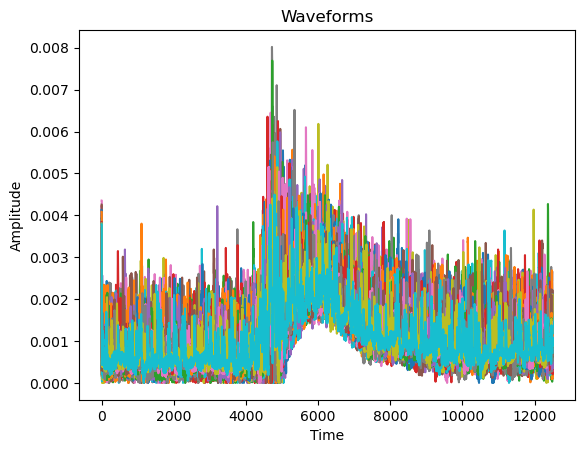

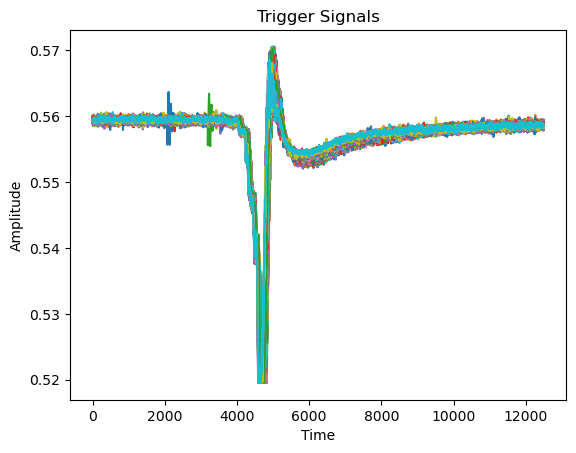

In [2]:
def read_data(filename, seg_len):
    filepath = "C:/Users/louis/OneDrive/Documents/University of Manchester/Physics/Year 4/MPhys/data/MPhys Sem 1 SiPM-Scintillation (KeySight Oscilloscope)/"
    data = np.genfromtxt(filepath + filename, delimiter=',', skip_header=3)
    n_segs = len(data) // seg_len

    waveforms = np.zeros((n_segs, seg_len, 3))
    for i in range(n_segs):
        waveforms[i] = data[i*seg_len:(i+1)*seg_len]

    np.nan_to_num(waveforms[:,:,2], copy=False, nan=0)

    for waveform in waveforms:
        waveform[:,2] += np.abs(np.min(waveform[:,2]))
        plt.plot(waveform[:, 2])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Waveforms")
    #plt.xlim(5800,6400)
    plt.show()

    for waveform in waveforms:
        plt.plot(waveform[:, 1])

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Trigger Signals")
    #plt.xlim(5800,6400)
    plt.show()

    return waveforms, n_segs

waveforms, n_segs = read_data("1000V_Ar_VUV_SiPM (06,12,2024).csv", 12500)

12500


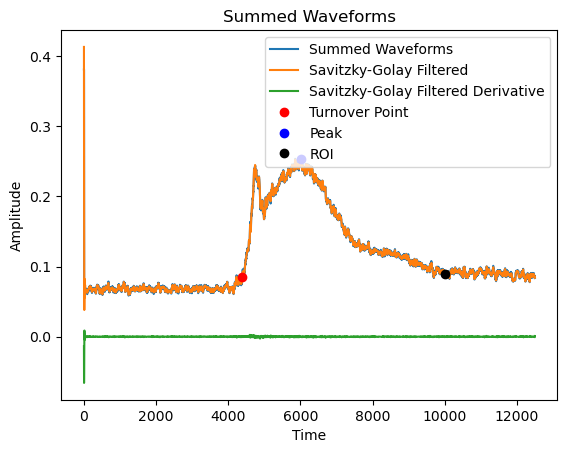

In [3]:
def find_roi(waveforms, n_segs, plot=False):

    for waveform in waveforms:
        waveform[:,2] += np.abs(np.min(waveform[:,2]))

    if plot==True:
        for i in range(n_segs):
            plt.plot(waveforms[i,:,2])
            plt.show()

    waveforms_sum = np.sum(waveforms, axis=0)
    savgol_filtered = savgol_filter(waveforms_sum[:, 2], 60, 9)
    savgol_filtered_deriv = savgol_filter(waveforms_sum[:, 2], 60, 9, deriv=1)

    print(len(savgol_filtered))

    turnover_point = np.argmin(np.abs(savgol_filtered_deriv[np.argmin(savgol_filtered_deriv):np.argmax(savgol_filtered_deriv)])) + np.argmin(savgol_filtered_deriv[500:])
    peak = np.argmax(savgol_filtered[500:])
    roi = [turnover_point, peak+4*(peak-turnover_point)]

    plt.plot(waveforms_sum[:, 2], label="Summed Waveforms")
    plt.plot(savgol_filtered, label="Savitzky-Golay Filtered")
    plt.plot(savgol_filtered_deriv, label="Savitzky-Golay Filtered Derivative")
    plt.plot(turnover_point, savgol_filtered[turnover_point], 'ro', label="Turnover Point")
    plt.plot(peak+500, savgol_filtered[peak+500], 'bo', label="Peak")
    plt.plot(roi[1], savgol_filtered[roi[1]], 'ko', label="ROI")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Summed Waveforms")
    plt.legend()
    #plt.xlim(2000,12000)
    #plt.ylim(-0.01, 0.01)
    plt.show()

    return turnover_point, (peak+500)

start, peak = find_roi(waveforms, n_segs, plot=False)

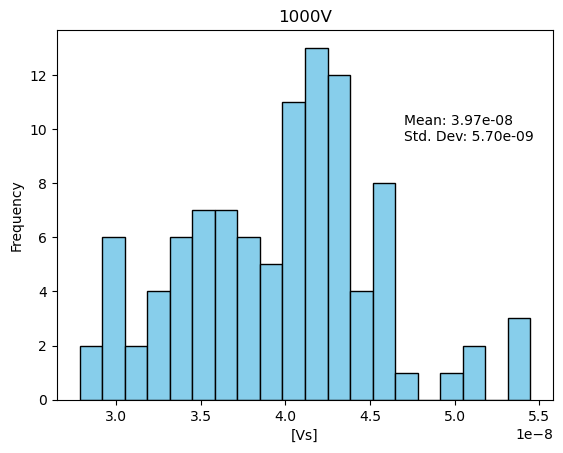

[4.279106636304174e-08,
 4.03672798012205e-08,
 4.511879437179199e-08,
 3.760339697742159e-08,
 4.272484043341294e-08,
 3.39502129279448e-08,
 4.258730904334172e-08,
 3.993258942239017e-08,
 4.121221702457149e-08,
 4.140533418234241e-08,
 5.170381101253922e-08,
 4.223671910215445e-08,
 4.710647215913904e-08,
 4.2252409481406406e-08,
 4.641792406768623e-08,
 4.003300363914232e-08,
 4.101702036054868e-08,
 4.5957442893773206e-08,
 4.034882789988379e-08,
 3.848752666664598e-08,
 3.791970241162043e-08,
 4.189973583168455e-08,
 3.740123381066214e-08,
 4.3346321592439344e-08,
 4.1246961795464916e-08,
 4.093347225386915e-08,
 5.436945114668551e-08,
 3.899433839770162e-08,
 4.549799103147368e-08,
 4.591490315103609e-08,
 4.280763958955899e-08,
 4.522314583222622e-08,
 4.160928814838097e-08,
 3.869647647826898e-08,
 4.242661448374705e-08,
 4.105422121666396e-08,
 3.528736773040976e-08,
 5.388799089974356e-08,
 4.130481952853014e-08,
 3.618223381788133e-08,
 3.6656154317002296e-08,
 3.6136928370

In [11]:
def integrate(waveforms, n_segs, start, peak):
    areas = []  # Store the area for each waveform

    for i in range(n_segs):
        # Extract x and y data for the current waveform
        x_data = waveforms[i, :, 0]
        y_data = waveforms[i, :, 2]

        end = np.argmin(np.abs(y_data[peak:] - y_data[peak]/10)) + peak

        area = 0
        for j in range(int(end-start)):
            area += (x_data[j+start+1] - x_data[j+start]) * (y_data[j+start] + y_data[j+start+1]) / 2
        
        areas.append(area)

        # Optional: Plot individual fits (uncomment for debugging)
        # fitted_peak = emg(x_data, *params)
        #plt.plot(x_data, y_data, '.', label="Noisy Data")
        #plt.plot(x_data[start], y_data[start], 'ro', label="Start")
        #plt.plot(x_data[peak], y_data[peak], 'bo', label="Peak")
        #plt.plot(x_data[end], y_data[end], 'ko', label="End")
        #plt.legend()
        #plt.show()
    
    mean = np.mean(areas)
    std_dev = np.std(areas)

    # Plot a histogram of the areas
    plt.hist(areas, bins=20, color='skyblue', edgecolor='black')
    plt.title("1000V")
    plt.xlabel("[Vs]")
    plt.ylabel("Frequency")
    plt.annotate(f"Mean: {mean:.2e}\nStd. Dev: {std_dev:.2e}", xy=(0.7, 0.7), xycoords='axes fraction')
    plt.show()

    return areas

integrate(waveforms, n_segs, start, peak)